<a href="https://colab.research.google.com/github/RomeroStats/welfare-spending-analysis-2025/blob/main/An%C3%A1lisis_Contratos_Bienestar_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis Contratos Bienestar 2025

## Bloque 1: Configuración, Carga y Auditoría

Carga de librerías, estilos y limpieza de la base de datos.

In [10]:
# Librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import matplotlib.dates as mdates
import warnings
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LinearRegression
from scipy.stats import skew, kurtosis
from google.colab import files

# Silenciar advertencias
warnings.filterwarnings("ignore")

# Definición de paleta de colores
C_AZUL_MCCI   = '#2C3E50'  # Azul Institucional
C_ROJO_ALERTA = '#B71C1C'  # Rojo Alerta
C_GRIS_ACERO  = '#95A5A6'  # Gris Contexto
C_FONDO       = '#FFFFFF'

# Configuración de estilo
sns.set_theme(style="white")
plt.rcParams['figure.facecolor'] = C_FONDO
plt.rcParams['axes.facecolor'] = C_FONDO
plt.rcParams['text.color'] = C_AZUL_MCCI
plt.rcParams['axes.labelcolor'] = '#7F8C8D'
plt.rcParams['xtick.color'] = '#7F8C8D'
plt.rcParams['ytick.color'] = '#7F8C8D'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlecolor'] = C_AZUL_MCCI
plt.rcParams['axes.titleweight'] = 'bold'

# Funciones auxiliares de estilo
def generar_escala_roja(n_colores):
    return sns.light_palette(C_ROJO_ALERTA, n_colors=n_colores, reverse=True)

def estilo_base(ax, titulo, subtitulo):
    sns.despine(left=True, bottom=True)
    ax.set_title(titulo.upper(), loc='left', fontsize=14, pad=20, color=C_AZUL_MCCI)
    ax.text(0, 1.02, subtitulo, transform=ax.transAxes, fontsize=11, color='#7F8C8D')
    ax.grid(axis='y', linestyle='-', alpha=0.2, color='#BDC3C7')
    ax.tick_params(axis='both', length=0)

# Carga, filtrado y descarga ---
print("Iniciando procesamiento de datos...")

try:
    # 1. Cargar csv
    df = pd.read_csv('contratos_2025.csv', encoding='latin-1', low_memory=False, on_bad_lines='skip')

    # Limpiar nombres de columnas
    df.columns = df.columns.str.strip()

    # 2. Filtrar por SIGLAS DE LA INSTITUCIÓN = BIENESTAR
    # Usamos upper() y strip() para asegurar que no fallen por mayúsculas o espacios
    if 'Siglas de la Institución' in df.columns:
        df_bienestar = df[df['Siglas de la Institución'].astype(str).str.strip().str.upper() == 'BIENESTAR'].copy()


        # Preparación para las gráficas

        # Montos a Millones de Pesos
        if 'Monto máximo con imp.' in df_bienestar.columns:
             df_bienestar['Monto_MDP'] = pd.to_numeric(df_bienestar['Monto máximo con imp.'], errors='coerce') / 1_000_000
        else:
             print("⚠️ No se encontró la columna de monto máximo. Verifica el nombre.")

        # Fechas
        if 'Fecha de firma del contrato' in df_bienestar.columns:
            df_bienestar['Fecha_Firma'] = pd.to_datetime(df_bienestar['Fecha de firma del contrato'], errors='coerce')

        # Texto de Procedimientos
        if 'Tipo Procedimiento' in df_bienestar.columns:
            df_bienestar['Tipo Procedimiento'] = df_bienestar['Tipo Procedimiento'].astype(str).str.upper().str.strip()

        # Crear DF limpio para análisis sin montos vacíos
        df_analisis = df_bienestar.dropna(subset=['Monto_MDP']).copy()

        print(f"\nDatos listos para los bloques de gráficas:")
        print(f"   - Contratos válidos para análisis financiero: {len(df_analisis):,.0f}")
        print(f"   - Monto Total Analizado: ${df_analisis['Monto_MDP'].sum()/1000:,.2f} MMDP")

    else:
        print("⚠️ ERROR: No se encontró la columna 'Siglas de la Institución'.")
        print("   Columnas disponibles:", df.columns.tolist())
        df_analisis = pd.DataFrame() # DataFrame vacío para no romper el código

except FileNotFoundError:
    print("❌ Error: Archivo 'contratos_2025.csv' no encontrado.")
    df_analisis = pd.DataFrame()

Iniciando procesamiento de datos...

Datos listos para los bloques de gráficas:
   - Contratos válidos para análisis financiero: 284
   - Monto Total Analizado: $2.73 MMDP


In [11]:
# Descarga de base de datos filtrada por la columna Siglas de la Institución: BIENESTAR
# También se puede filtrar por la columna Institución: SECRETARIA DE BIENESTAR

if 'df_bienestar' in locals() and not df_bienestar.empty:
    nombre_archivo = 'Base_Datos_BIENESTAR_2025_Filtrada.csv'

    print(f"📥 Preparando descarga de: {nombre_archivo}")
    print(f"   - Contiene {len(df_bienestar):,.0f} registros.")

    # Guardar y descargar
    df_bienestar.to_csv(nombre_archivo, index=False, encoding='utf-8-sig')
    files.download(nombre_archivo)
else:
    print("⚠️ No hay datos filtrados para descargar. Ejecuta el Bloque 1 primero.")

📥 Preparando descarga de: Base_Datos_BIENESTAR_2025_Filtrada.csv
   - Contiene 1,326 registros.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Bloque 2: Gráfica Concentración de Proveedores

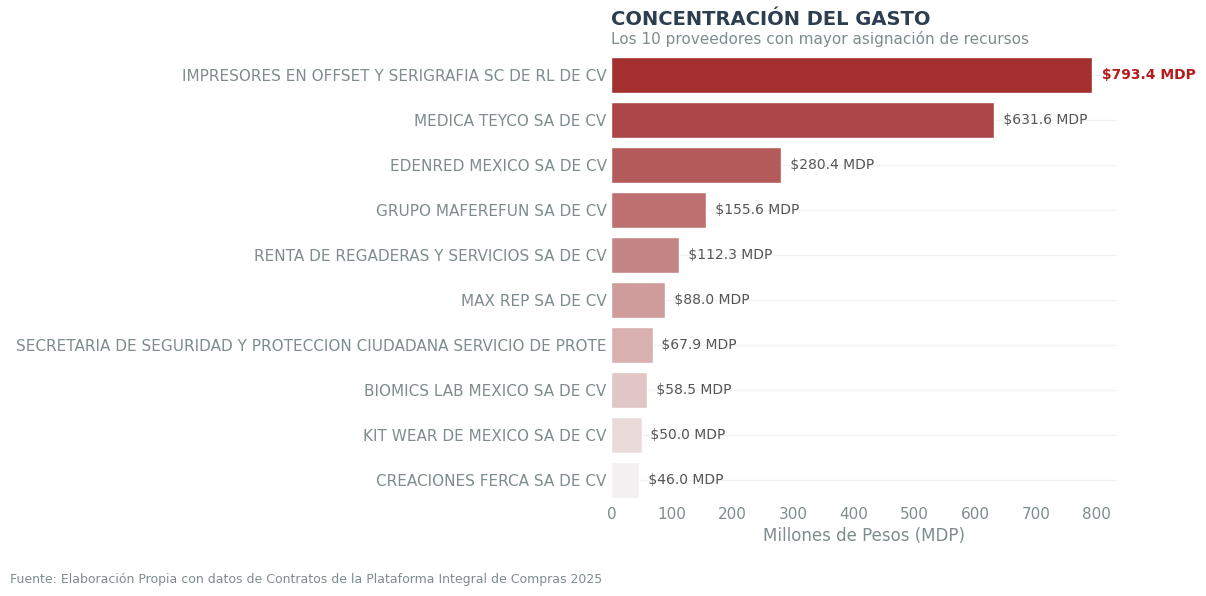

In [12]:
# Gráfica 1: Concentración del gasto
if 'df_analisis' in locals() and not df_analisis.empty:
    top_prov = df_analisis.groupby(['rfc', 'Proveedor o contratista'])['Monto_MDP'].sum().sort_values(ascending=False).head(10).reset_index()

    plt.figure(figsize=(12, 6))
    ax1 = sns.barplot(data=top_prov, x='Monto_MDP', y='Proveedor o contratista',
                      palette=generar_escala_roja(10), hue='Proveedor o contratista', legend=False)

    for i, v in enumerate(top_prov['Monto_MDP']):
        color_txt = C_ROJO_ALERTA if i == 0 else '#555555'
        weight = 'bold' if i == 0 else 'normal'
        ax1.text(v + (top_prov['Monto_MDP'].max()*0.01), i, f' ${v:,.1f} MDP',
                 va='center', color=color_txt, fontweight=weight, fontsize=10)

    estilo_base(ax1, "Concentración del Gasto", "Los 10 proveedores con mayor asignación de recursos")
    plt.xlabel('Millones de Pesos (MDP)')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('visual_top_proveedores.png', dpi=300)
    plt.figtext(0.01, 0.01, "Fuente: Elaboración Propia con datos de Contratos de la Plataforma Integral de Compras 2025", ha='left', va='bottom', fontsize=9, color='#7F8C8D')
    plt.subplots_adjust(bottom=0.15)
    plt.show()

## Bloque 3: Gráfica de Riesgo

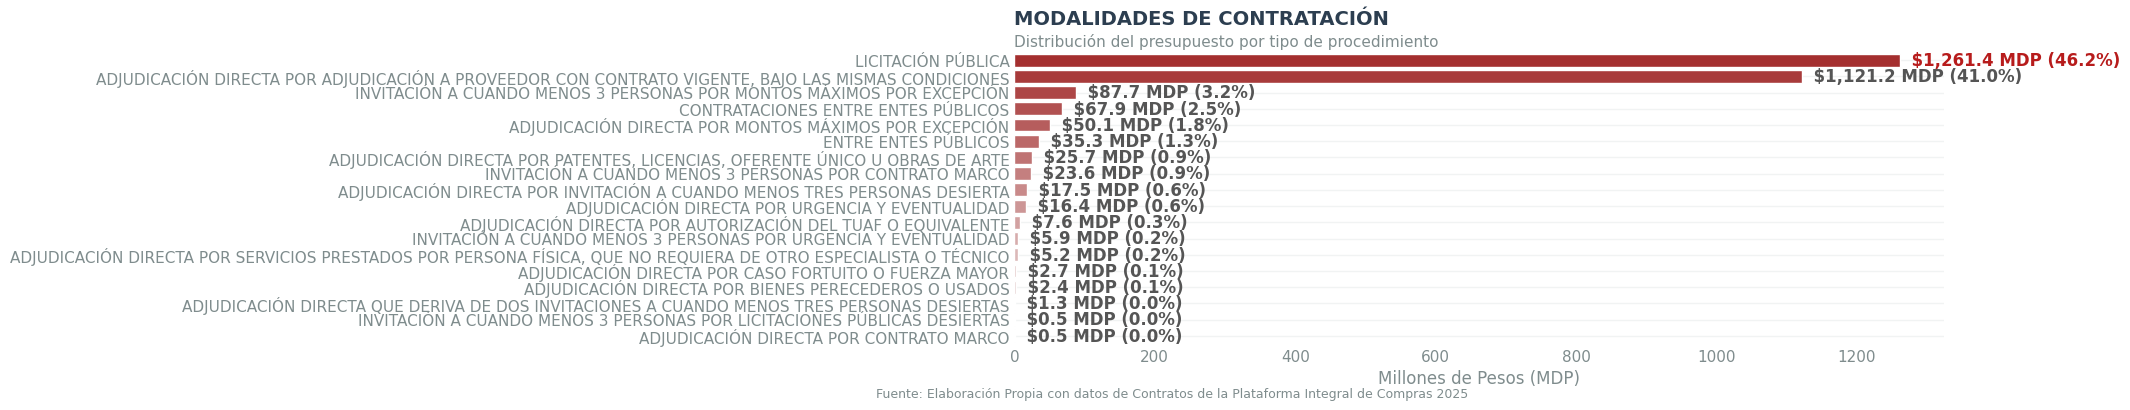

In [13]:
# Gráfica 2: Modalidades de contratación
if 'df_analisis' in locals() and not df_analisis.empty:
    modalidad = df_analisis.groupby('Tipo Procedimiento')['Monto_MDP'].sum().sort_values(ascending=False).reset_index()
    total = modalidad['Monto_MDP'].sum()

    plt.figure(figsize=(12, 4))
    ax2 = sns.barplot(data=modalidad, x='Monto_MDP', y='Tipo Procedimiento',
                      palette=generar_escala_roja(len(modalidad)), hue='Tipo Procedimiento', legend=False)

    for i, row in modalidad.iterrows():
        pct = (row['Monto_MDP']/total)*100
        color_txt = C_ROJO_ALERTA if i == 0 else '#555555'
        ax2.text(row['Monto_MDP'], i, f"  ${row['Monto_MDP']:,.1f} MDP ({pct:.1f}%)",
                 va='center', fontweight='bold', color=color_txt)

    estilo_base(ax2, "Modalidades de Contratación", "Distribución del presupuesto por tipo de procedimiento")
    plt.xlabel('Millones de Pesos (MDP)')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('visual_modalidades.png', dpi=300)
    plt.figtext(0.01, 0.01, "Fuente: Elaboración Propia con datos de Contratos de la Plataforma Integral de Compras 2025", ha='left', va='bottom', fontsize=9, color='#7F8C8D')
    plt.subplots_adjust(bottom=0.15)
    plt.show()

## Bloque 4: Gráfica Estacionalidad

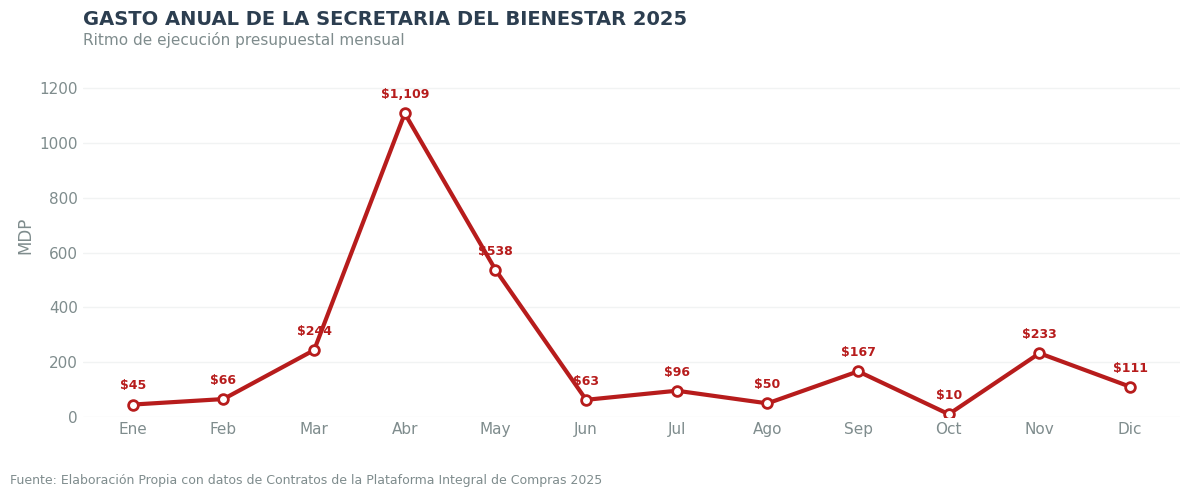


Detalles del Gasto en el Mes de Abril
   Se encontraron 29 contratos firmados en Abril.
   A continuación se muestran los 5 contratos con mayor presupuesto de este mes:


,Concepto / Expediente,Proveedor Adjudicado,Tipo de Adjudicación,Monto Total (MDP)
0,ADQUISICIÓN DE EQUIPOS E INSUMOS MÉDICOS (TIRAS REACTIVAS Y OXIMETRO),MEDICA TEYCO SA DE CV,"ADJUDICACIÓN DIRECTA POR ADJUDICACIÓN A PROVEEDOR CON CONTRATO VIGENTE, BAJO LAS MISMAS CONDICIONES",631.56
1,SERVICIO INTEGRAL DE ARRENDAMIENTO DE MOBILIARIO PORTÁTIL Y SERVICIOS ADICIONALE,RENTA DE REGADERAS Y SERVICIOS SA DE CV,LICITACIÓN PÚBLICA,112.34
2,ADQUISICIÓN DE EQUIPO DE CÓMPUTO TIPO TABLET PARA EL PERSONAL DEL PROGRAMA SALU,MAX REP SA DE CV,LICITACIÓN PÚBLICA,88.02
3,"SERVICIO DE PROTECCIÓN, CUSTODIA, VIGILANCIA Y SEGURIDAD EN INSTALACIONES DE LA",SECRETARIA DE SEGURIDAD Y PROTECCION CIUDADANA SERVICIO DE PROTE,CONTRATACIONES ENTRE ENTES PÚBLICOS,67.92
4,ADQUISICIÓN DE EQUIPOS E INSUMOS MÉDICOS PARA EL PERSONAL DEL PROGRAMA SALUD,BIOMICS LAB MEXICO SA DE CV,"ADJUDICACIÓN DIRECTA POR ADJUDICACIÓN A PROVEEDOR CON CONTRATO VIGENTE, BAJO LAS MISMAS CONDICIONES",48.40


In [20]:
# Gráfica 3: Gasto por mes y revisón del mes de abril
if 'df_analisis' in locals() and not df_analisis.empty:
    # Preparación de datos mensuales
    meses = {1:'Ene', 2:'Feb', 3:'Mar', 4:'Abr', 5:'May', 6:'Jun',
             7:'Jul', 8:'Ago', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dic'}

    gasto_mes = df_analisis.groupby(df_analisis['Fecha_Firma'].dt.month)['Monto_MDP'].sum().reset_index()
    gasto_mes.columns = ['Mes_Num', 'Monto_MDP']

    # Gráficación
    plt.figure(figsize=(12, 5))
    ax3 = plt.gca()
    plt.plot(gasto_mes['Mes_Num'].map(meses), gasto_mes['Monto_MDP'],
             color=C_ROJO_ALERTA, linewidth=3, marker='o', markersize=7, markerfacecolor='white', markeredgewidth=2)

    for i, v in enumerate(gasto_mes['Monto_MDP']):
        ax3.text(i, v + (gasto_mes['Monto_MDP'].max()*0.05), f"${v:,.0f}",
                 ha='center', fontsize=9, color=C_ROJO_ALERTA, fontweight='bold')

    estilo_base(ax3, "Gasto Anual de la Secretaria del Bienestar 2025", "Ritmo de ejecución presupuestal mensual")
    plt.ylim(0, gasto_mes['Monto_MDP'].max()*1.2)
    plt.ylabel('MDP')
    plt.xlabel('')
    plt.tight_layout()
    plt.savefig('visual_estacionalidad.png', dpi=300)
    plt.figtext(0.01, 0.01, "Fuente: Elaboración Propia con datos de Contratos de la Plataforma Integral de Compras 2025", ha='left', va='bottom', fontsize=9, color='#7F8C8D')
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # Tabla de los 5 principales proveedores en abril

    # Filtramos solo el mes 4
    df_abril = df_analisis[df_analisis['Fecha_Firma'].dt.month == 4].copy()

    print("\n" + "="*60)
    print("Detalles del Gasto en el Mes de Abril")
    print("="*60)

    if not df_abril.empty:
        # Agrupamos por Título, Proveedor y Tipo de Procedimiento
        top_abril = df_abril.groupby(['Título del expediente', 'Proveedor o contratista', 'Tipo Procedimiento'])['Monto_MDP'].sum().nlargest(5).reset_index()

        # Renombramos columnas para presentación
        top_abril.columns = ['Concepto / Expediente', 'Proveedor Adjudicado', 'Tipo de Adjudicación', 'Monto Total (MDP)']

        print(f"   Se encontraron {len(df_abril)} contratos firmados en Abril.")
        print(f"   A continuación se muestran los 5 contratos con mayor presupuesto de este mes:")

        display(top_abril.style.format({'Monto Total (MDP)': '{:,.2f}'}))
    else:
        print("   ⚠️ No se encontraron registros para el mes de Abril en la base limpia.")

## Bloque 5: Análisis Estadístico y Boxplots


Sección de Estadística Descriptiva y Distribución

[1] Estadísticos Generales con Montos en MDP
--------------------------------------------------
   • Total Contratos:      284
   • Promedio:             $9.62 MDP
   • Mediana (50%):        $0.38 MDP
   • Máximo:               $631.56 MDP
--------------------------------------------------


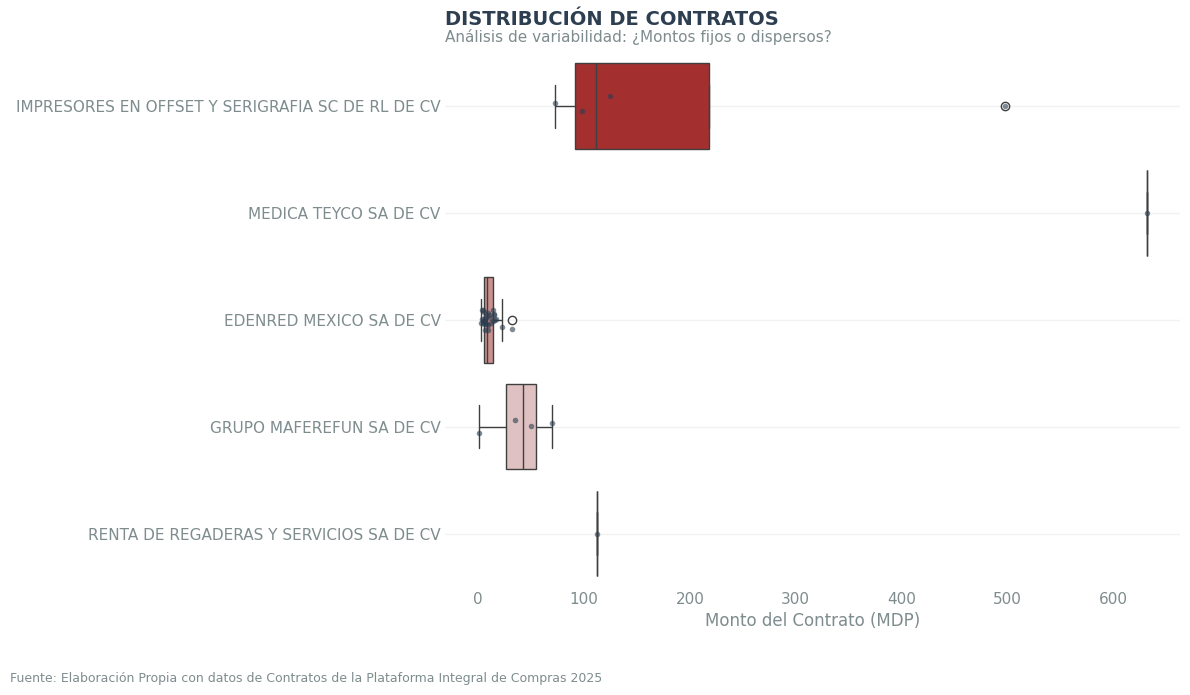


[2] Detalles de los Primeros 5 Contratistas de la Secretaría del Bienestar


In [22]:
# Análisis Estadístico y Boxplots
print("\n" + "="*60)
print("Sección de Estadística Descriptiva y Distribución")
print("="*60)

if 'df_analisis' in locals() and not df_analisis.empty:

    # Estadística descriptiva
    datos_monto = df_analisis['Monto_MDP']
    stats_desc = datos_monto.describe(percentiles=[.25, .5, .75, .90, .99])

    print(f"\n[1] Estadísticos Generales con Montos en MDP")
    print("-" * 50)
    print(f"   • Total Contratos:      {stats_desc['count']:,.0f}")
    print(f"   • Promedio:             ${stats_desc['mean']:,.2f} MDP")
    print(f"   • Mediana (50%):        ${stats_desc['50%']:,.2f} MDP")
    print(f"   • Máximo:               ${stats_desc['max']:,.2f} MDP")
    print("-" * 50)

    # Boxplots
    top_5_nombres = df_analisis.groupby('Proveedor o contratista')['Monto_MDP'].sum().nlargest(5).index
    df_top5 = df_analisis[df_analisis['Proveedor o contratista'].isin(top_5_nombres)].copy()

    plt.figure(figsize=(12, 7))
    ax_box = sns.boxplot(data=df_top5, x='Monto_MDP', y='Proveedor o contratista',
                          order=top_5_nombres, palette=generar_escala_roja(5))

    sns.stripplot(data=df_top5, x='Monto_MDP', y='Proveedor o contratista',
                  order=top_5_nombres, color='#2C3E50', alpha=0.6, size=4, jitter=True)

    estilo_base(ax_box, "Distribución de Contratos", "Análisis de variabilidad: ¿Montos fijos o dispersos?")
    plt.xlabel('Monto del Contrato (MDP)')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('visual_boxplot_top5.png', dpi=300)
    plt.figtext(0.01, 0.01, "Fuente: Elaboración Propia con datos de Contratos de la Plataforma Integral de Compras 2025", ha='left', va='bottom', fontsize=9, color='#7F8C8D')
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    # Tabla
    # Se agrupa por Proveedor y Tipo de Procedimiento para ver cómo se les adjudicó
    tabla_top5 = df_top5.groupby(['Proveedor o contratista', 'Tipo Procedimiento'])['Monto_MDP'].agg(
        ['count', 'sum', 'mean', 'median', 'max', 'std']
    ).sort_values(by='sum', ascending=False) # Ordenamos por monto total para mantener el orden

    tabla_top5.columns = ['# Contratos', 'Monto Total', 'Promedio', 'Mediana', 'Max Contrato', 'Desv. Std']
    print(f"\n[2] Detalles de los Primeros 5 Contratistas de la Secretaría del Bienestar")

    display(tabla_top5.style.format("{:,.2f}"))

# Interpretación

Al realizar el análisis estadístico de las contrataciones de la Secretaría de Bienestar durante el ejercicio 2025, se descubre una profunda grieta en la forma en que se distribuyen los recursos públicos. Los datos revelan que la institución opera bajo una lógica sin medias tintas, no existe una "clase media" de proveedores.

Por un lado, se observa un inmenso volumen de contratos operativos de montos modestos, que representan la realidad cotidiana de la mayoría de las empresas contratadas; por el otro, existe una élite reducida que concentra cantidades desproporcionadas de dinero, generando una distorsión en la distribución del presupuesto en los coontratos considerable.

Esta desigualdad se hace evidente al contrastar el promedio de los contratos con la realidad del proveedor que recibe contratos con montos reducidos. Aunque las cifras generales podrían sugerir que la Secretaría otorga contratos con presupuestos elevados de manera regular, la mediana estadística muestra que la mitad de las adjudicaciones apenas superan los 380 mil pesos. Sin embargo, el promedio se dispara a cifras por encima de los 9 millones de pesos debido al peso de unos pocos contratos. El promedio es distorsionado por una concentración excesiva de valores atípicos otorgados a unos cuantos proveedores por adjudicación directa.

## Bloque 6: Gráfica de identificación de valores atípicos

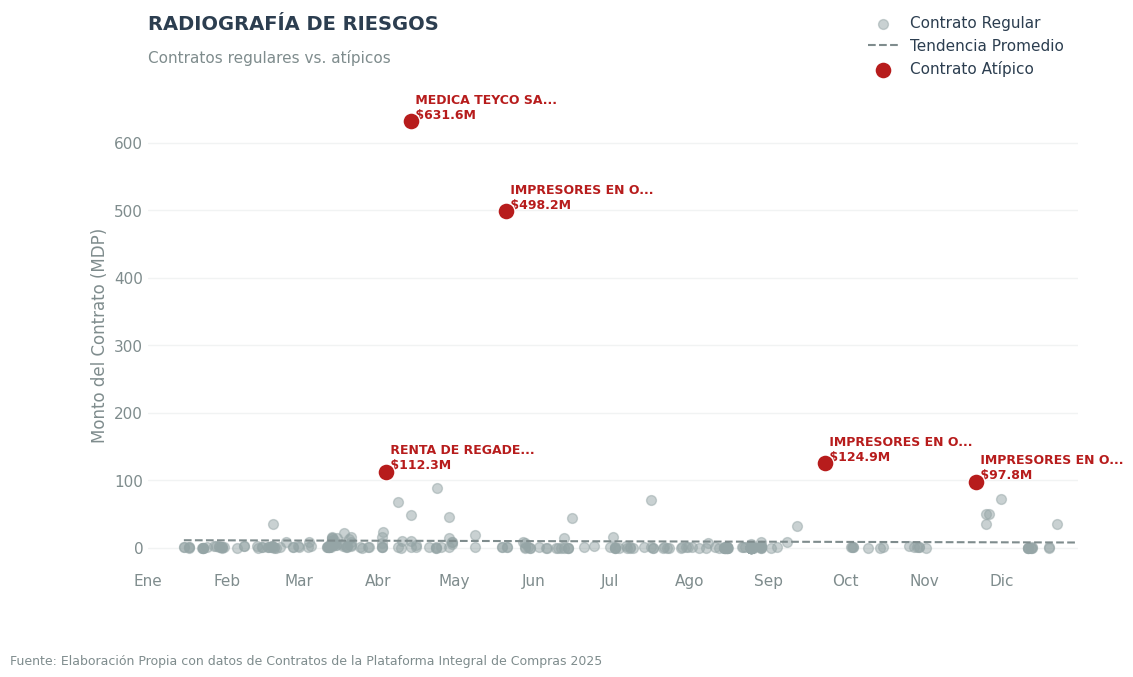

In [16]:
# Gráfica 4: Radiografía de Riesgos
if 'df_analisis' in locals() and not df_analisis.empty:

    # Preparación de los datos
    df_reg = df_analisis.dropna(subset=['Fecha_Firma']).sort_values('Fecha_Firma').copy()
    df_reg['Fecha_Ordinal'] = df_reg['Fecha_Firma'].map(datetime.datetime.toordinal)

    model = LinearRegression().fit(df_reg[['Fecha_Ordinal']].values, df_reg['Monto_MDP'].values)
    df_reg['Pred'] = model.predict(df_reg[['Fecha_Ordinal']].values)
    top_outliers = df_reg.nlargest(5, 'Monto_MDP')

    plt.figure(figsize=(12, 7))
    ax4 = plt.gca()

    # Visualización
    plt.scatter(df_reg['Fecha_Firma'], df_reg['Monto_MDP'],
                color=C_GRIS_ACERO, s=50, alpha=0.5, label='Contrato Regular')

    plt.plot(df_reg['Fecha_Firma'], df_reg['Pred'],
             color='#7F8C8D', linestyle='--', linewidth=1.5, label='Tendencia Promedio')

    plt.scatter(top_outliers['Fecha_Firma'], top_outliers['Monto_MDP'],
                color=C_ROJO_ALERTA, s=150, edgecolor='white', zorder=5, label='Contrato Atípico')

    for _, row in top_outliers.iterrows():
        ax4.text(row['Fecha_Firma'], row['Monto_MDP'],
                 f" {str(row['Proveedor o contratista'])[:15]}...\n ${row['Monto_MDP']:.1f}M",
                 fontsize=9, fontweight='bold', color=C_ROJO_ALERTA, ha='left', va='bottom')

    ax4.set_xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-12-31'))
    ax4.xaxis.set_major_locator(mdates.MonthLocator())
    ax4.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: meses.get(mdates.num2date(x).month, "")))

    sns.despine(left=True, bottom=True)

    ax4.text(0, 1.15, "RADIOGRAFÍA DE RIESGOS", transform=ax4.transAxes,
             fontsize=14, fontweight='bold', color=C_AZUL_MCCI)

    ax4.text(0, 1.08, "Contratos regulares vs. atípicos",
             transform=ax4.transAxes, fontsize=11, color='#7F8C8D')

    plt.legend(frameon=False, loc='lower right', bbox_to_anchor=(1, 1.02), ncol=1)

    ax4.grid(axis='y', linestyle='-', alpha=0.2, color='#BDC3C7')
    ax4.tick_params(axis='both', length=0)
    plt.ylabel('Monto del Contrato (MDP)')
    plt.figtext(0.01, 0.01, "Fuente: Elaboración Propia con datos de Contratos de la Plataforma Integral de Compras 2025",
                ha='left', va='bottom', fontsize=9, color='#7F8C8D')

    plt.subplots_adjust(top=0.82, bottom=0.15)

    plt.savefig('visual_outliers.png', dpi=300)
    plt.show()

# Interpretación

Los cinco proveedores principales arrojan señales de alerta sobre los mecanismos de planeación. Estos grandes contratistas presentan un comportamiento financiero errático, sus montos de adjudicación no son constantes ni previsibles, sino que fluctúan entre cifras moderadas y asignaciones masivas. Esto suele ser un indicio de que las contrataciones obedecen a una lógica de asignación discrecional de grandes contratos, muchas veces amparadas bajo figuras distintas a la licitación pública.

La estructura de los datos sugiere que los mecanismos de competencia, como las licitaciones, podrían estar siendo relegados a un segundo plano. Aunque numéricamente existan muchos procesos competitivos, el peso financiero real del gasto se decide en las Adjudicaciones Directas. Esto configura un escenario donde el grueso del dinero público fluye hacia proveedores recurrentes, dejando al mercado abierto compitiendo únicamente por los remanentes del presupuesto.

## Bloque 7: Cruce con las Bases de Datos del SAT



In [17]:

print("\n" + "="*60)
print("Auditoria: Cruce con Listas del SAT (ART. 69-B Y 69-B Bis del Código Fiscal de la Federación)")
print("="*60)

archivo_69b = 'Listado_Completo_69-B.csv'
archivo_global = 'ListadoGlobalDefinitivo.csv'
rfcs_negros = set()

try:
    # Carga de Empresas que Facturan Operaciones Simuladas (EFOS)
    df_69b = pd.read_csv(archivo_69b, encoding='latin-1', header=2)
    if 'Situación del contribuyente' in df_69b.columns:
        efos = df_69b[df_69b['Situación del contribuyente'] == 'Definitivo']['RFC']
        rfcs_negros.update(efos.astype(str).str.strip().str.upper())
        print(f"   ✅ Listado de Empresas que Facturan Operaciones Simuladas 69-B cargado: {len(efos):,.0f} registros.")

    # Carga Global
    df_global = pd.read_csv(archivo_global, encoding='latin-1', header=2)
    if 'RFC' in df_global.columns:
        rfcs_global = df_global['RFC']
        rfcs_negros.update(rfcs_global.astype(str).str.strip().str.upper())
        print(f"   ✅ Listado 69-B Bis cargado: {len(rfcs_global):,.0f} registros.")

    # Cruce
    print(f"   🔍 Ejecutando verificación contra padrón de proveedores...")
    df_analisis['RFC_Clean'] = df_analisis['rfc'].astype(str).str.strip().str.upper()
    match_sat = df_analisis[df_analisis['RFC_Clean'].isin(rfcs_negros)].copy()

    # Resultados
    if not match_sat.empty:
        print(f"\n   ⚠️ ALERTA: Se detectaron {match_sat['RFC_Clean'].nunique()} proveedores boletinados.")
        display(match_sat[['Fecha_Firma', 'rfc', 'Proveedor o contratista', 'Monto_MDP']])
        match_sat.to_csv('EVIDENCIA_SAT_MATCH.csv', index=False)
    else:
        print("\n   ✅ RESULTADO NEGATIVO: No se encontraron coincidencias con los listados de definitivos cargados.")

except FileNotFoundError:
    print("\n   ❌ Aviso: No se pudieron realizar los cruces. Verifique que los archivos del SAT estén cargados.")
except Exception as e:
    print(f"\n   ⚠️ Error técnico durante la auditoría: {e}")


Auditoria: Cruce con Listas del SAT (ART. 69-B Y 69-B Bis del Código Fiscal de la Federación)
   ✅ Listado de Empresas que Facturan Operaciones Simuladas 69-B cargado: 11,270 registros.
   ✅ Listado 69-B Bis cargado: 3 registros.
   🔍 Ejecutando verificación contra padrón de proveedores...

   ✅ RESULTADO NEGATIVO: No se encontraron coincidencias con los listados de definitivos cargados.
